# Forecast of Leios profitability

## Load libraries

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(R.utils, quietly=TRUE)
    require(stringr, quietly=TRUE)
    require(showtext, quietly=TRUE)
})

## Cost, transaction, and revenue data

All data comes from [github:input-output-hk/ouroboros-leios/docs/cost-estimate](https://github.com/input-output-hk/ouroboros-leios/tree/3013c9dfe6ee9bf28cf383c9ee58959978583d7b/docs/cost-estimate).

### Cost by cloud provider

In [2]:
costs <- data.table(
    `IB rate [IB/s]`=c(0.05, 1, 5, 10, 20, 30),
    `AWS`=c(92.84, 233.04, 804.85, 1489.42, 2901.77, 4190.02),
    `GCP`=c(114.11, 290.55, 1006.59, 1856.98, 3562.79, 5116.16),
    `Azure`=c(93.26, 227.85, 781.99, 1441.20, 2813.08, 4061.59),
    `DO`=c(66.28, 108.61, 298.89, 524.77, 989.11, 1369.45),
    `Linode`=c(64.75, 92.41, 161.69, 365.72, 746.61, 1067.50),
    `Hertzner`=c(15.98, 31.52, 97.77, 176.71, 330.70, 469.61)
)
costs

IB rate [IB/s],AWS,GCP,Azure,DO,Linode,Hertzner
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.05,92.84,114.11,93.26,66.28,64.75,15.98
1.00,233.04,290.55,227.85,108.61,92.41,31.52
5.00,804.85,1006.59,781.99,298.89,161.69,97.77
10.00,1489.42,1856.98,1441.20,524.77,365.72,176.71
20.00,2901.77,3562.79,2813.08,989.11,746.61,330.70
30.00,4190.02,5116.16,4061.59,1369.45,1067.50,469.61


In [3]:
costs1 <- melt(costs, id.vars="IB rate [IB/s]", variable.name="Provider", value.name="Cost [USD/month]")

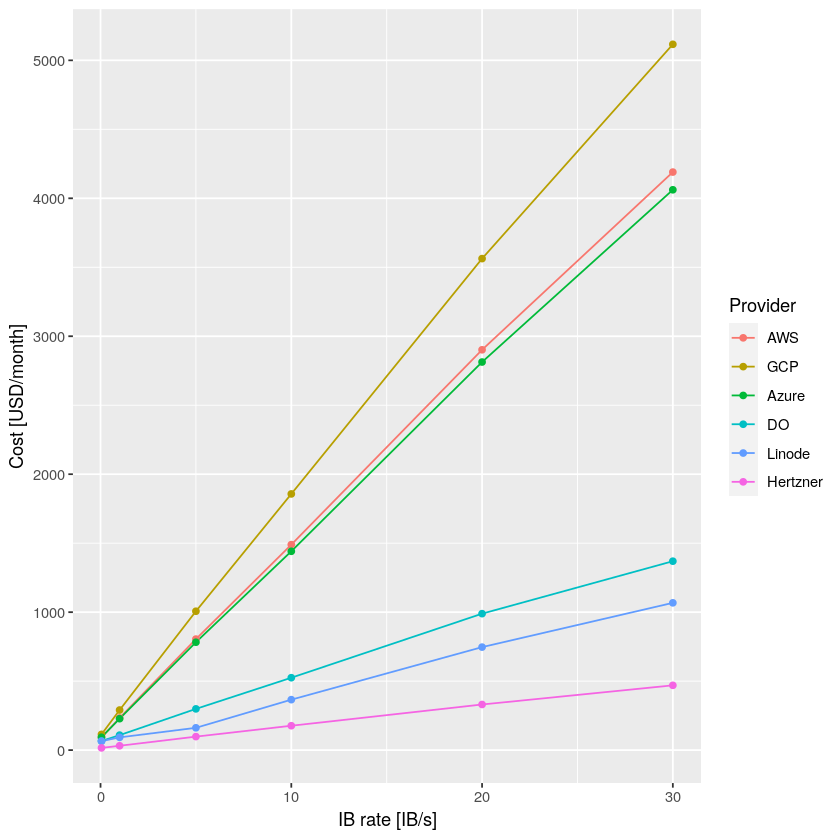

In [4]:
ggplot(costs1, aes(x=`IB rate [IB/s]`, y=`Cost [USD/month]`, color=`Provider`)) +
    geom_line() +
    geom_point()

### Throughput

Relate the IB rate to the transaction rate.

In [5]:
rates <- as.data.table(matrix(c(
    0.05, 3.5, 19.65, 0.3,
    1, 70, 393, 6,
    5, 350, 1965, 30,
    10, 700, 3930, 60,
    20, 1400, 7860, 120,
    30, 2100, 11790, 180
), ncol=4, byrow=TRUE, dimnames=list(NULL, c("IB rate [IB/s]", "Typical", "Smallest", "Largest"))))
rates

IB rate [IB/s],Typical,Smallest,Largest
<dbl>,<dbl>,<dbl>,<dbl>
0.05,3.5,19.65,0.3
1.00,70.0,393.00,6.0
5.00,350.0,1965.00,30.0
10.00,700.0,3930.00,60.0
20.00,1400.0,7860.00,120.0
30.00,2100.0,11790.00,180.0


In [6]:
rates1 <- melt(rates, id.vars="IB rate [IB/s]", variable.name="Transaction size", value.name="Transaction rate [tx/s]")

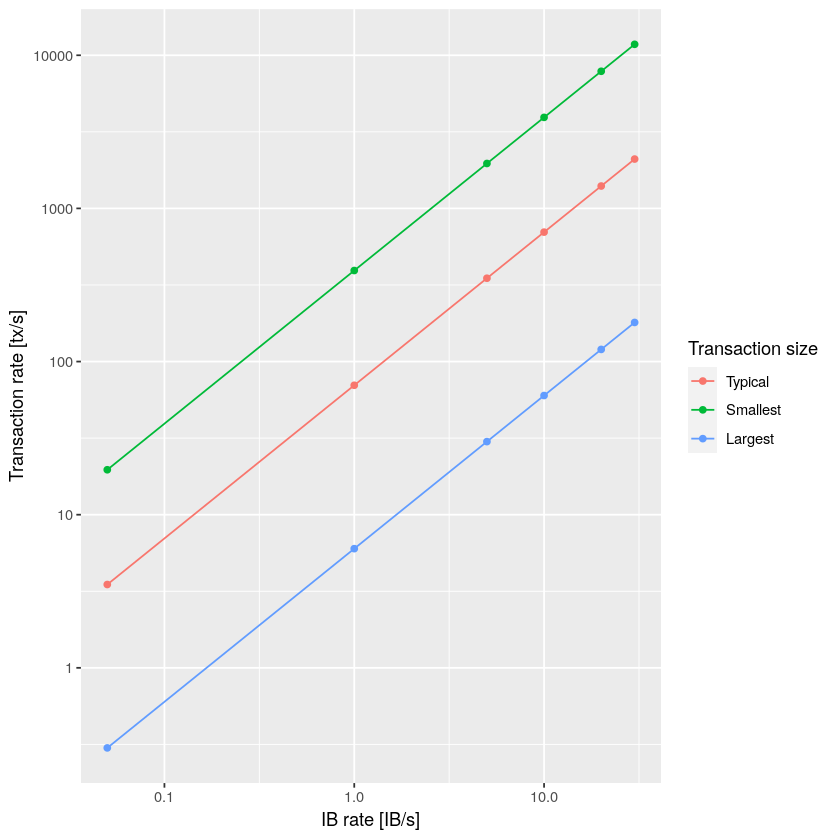

In [7]:
ggplot(rates1, aes(x=`IB rate [IB/s]`, y=`Transaction rate [tx/s]`, color=`Transaction size`)) +
    geom_line() +
    geom_point() +
    scale_x_log10() +
    scale_y_log10()

### Fees

In [8]:
fees <- as.data.table(matrix(c(
    0.05, 1969768.85, 8474945.16, 669750.34,
    1, 39395377.00, 169498903.20, 13395006.80,
    5, 196976885.00, 847494516.00, 66975034.00,
    10, 393953770.00, 1694989032.00, 133950068.00,
    20, 787907540.00, 3389978064.00, 267900136.00,
    30, 1181861310.00, 5084967096.00, 401850204.00
), ncol=4, byrow=TRUE, dimnames=list(NULL, c("IB rate [IB/s]", "Typical", "Smallest", "Largest"))))
fees

IB rate [IB/s],Typical,Smallest,Largest
<dbl>,<dbl>,<dbl>,<dbl>
0.05,1969769,8474945,669750.3
1.00,39395377,169498903,13395006.8
5.00,196976885,847494516,66975034.0
10.00,393953770,1694989032,133950068.0
20.00,787907540,3389978064,267900136.0
30.00,1181861310,5084967096,401850204.0


In [9]:
# Sanity check:

fees[`IB rate [IB/s]` == 0.05, `Typical`] *  # This IB rate corresponds to a full Praos block.
  0.16 *                                     # Block utilization
  12 / (365.24 / 5) *                        # Convert from months to epochs
  0.45                                       # Price of ADA in November 2024

[1] 23298.11

In [10]:
fees1 <- melt(fees, id.vars="IB rate [IB/s]", variable.name="Transaction size", value.name="Revenue [USD/month]")

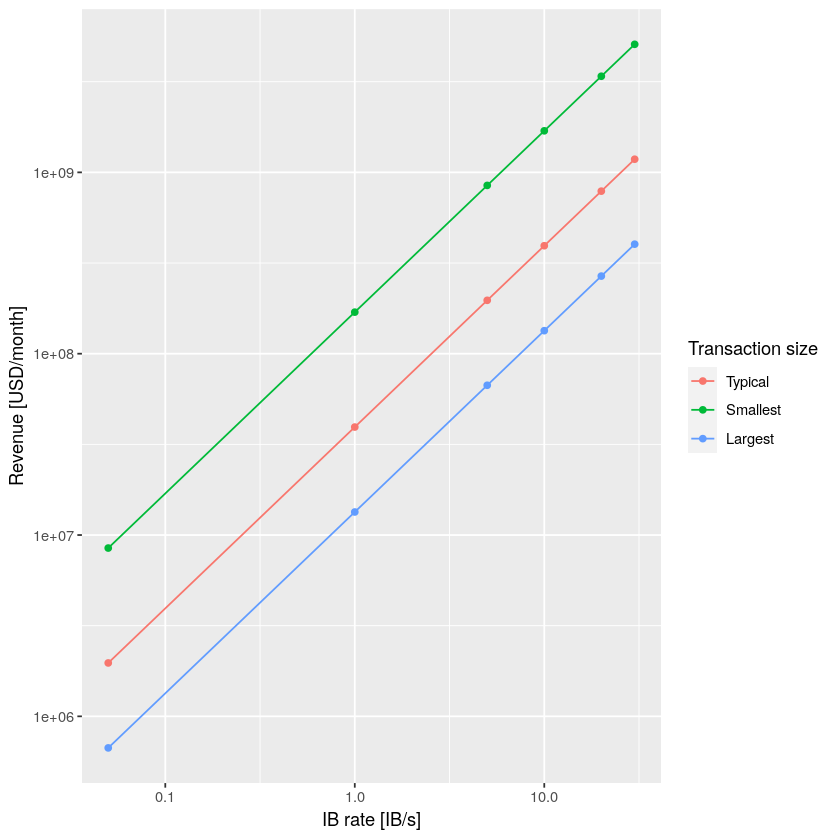

In [11]:
ggplot(fees1, aes(x=`IB rate [IB/s]`, y=`Revenue [USD/month]`, color=`Transaction size`)) +
    geom_line() +
    geom_point() +
    scale_x_log10() +
    scale_y_log10()

## First cut at computing financial viability

Assume 3000 SPOs each running 3 nodes and collecting 21% of rewards.

In [12]:
spoCount <- 3000
spoNodes <- 3
spoFeeFraction <- 0.21

### Organize data for plotting

In [13]:
results <- costs1[
    fees1[
        rates1, 
        on=c("IB rate [IB/s]", "Transaction size")
    ], 
    on="IB rate [IB/s]", 
    allow.cartesian=TRUE
][,.(
    `IB rate [IB/s]`,
    `Provider`,
    `Transaction size`,
    `Transaction rate [tx/s]`,
    `SPO cost [USD/month]`=spoNodes*`Cost [USD/month]`,
    `SPO fee revenue [USD/month]`=`Revenue [USD/month]`*spoFeeFraction/spoCount,
    `SPO net income [USD/month]`=`Revenue [USD/month]`*spoFeeFraction/spoCount-spoNodes*`Cost [USD/month]`,
    `SPO revenue/cost [%/100]`=`Revenue [USD/month]`*spoFeeFraction/spoCount/spoNodes/`Cost [USD/month]`
)]
results %>% summary

 IB rate [IB/s]      Provider  Transaction size Transaction rate [tx/s]
 Min.   : 0.05   AWS     :18   Typical :36      Min.   :    0.3        
 1st Qu.: 1.00   GCP     :18   Smallest:36      1st Qu.:   30.0        
 Median : 7.50   Azure   :18   Largest :36      Median :  265.0        
 Mean   :11.01   DO      :18                    Mean   : 1721.0        
 3rd Qu.:20.00   Linode  :18                    3rd Qu.: 1965.0        
 Max.   :30.00   Hertzner:18                    Max.   :11790.0        
 SPO cost [USD/month] SPO fee revenue [USD/month] SPO net income [USD/month]
 Min.   :   47.94     Min.   :    46.9            Min.   :  -295.4          
 1st Qu.:  338.20     1st Qu.:  2757.7            1st Qu.:  2070.2          
 Median : 1252.99     Median : 16270.7            Median : 12275.7          
 Mean   : 3171.35     Mean   : 57097.5            Mean   : 53926.1          
 3rd Qu.: 4162.16     3rd Qu.: 59324.6            3rd Qu.: 57341.0          
 Max.   :15348.48     Max.   :3559

### Net income as a function of transaction rate

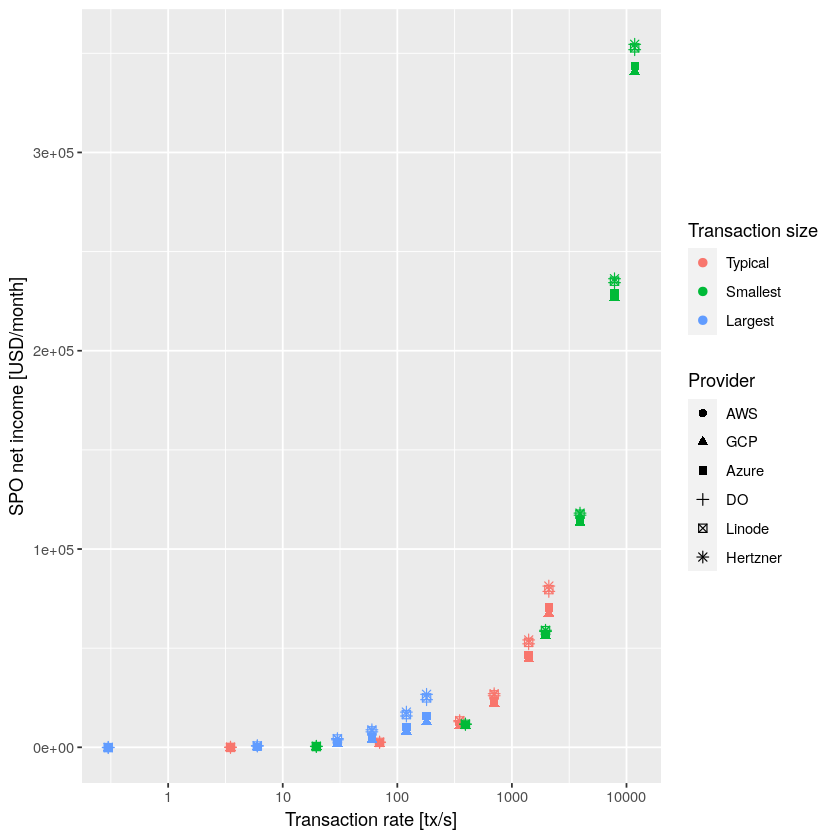

In [14]:
ggplot(results, aes(x=`Transaction rate [tx/s]`, y=`SPO net income [USD/month]`, color=`Transaction size`, shape=`Provider`)) +
    geom_point(size=2) +
    scale_x_log10()

Zoom in so the negative values are visible.

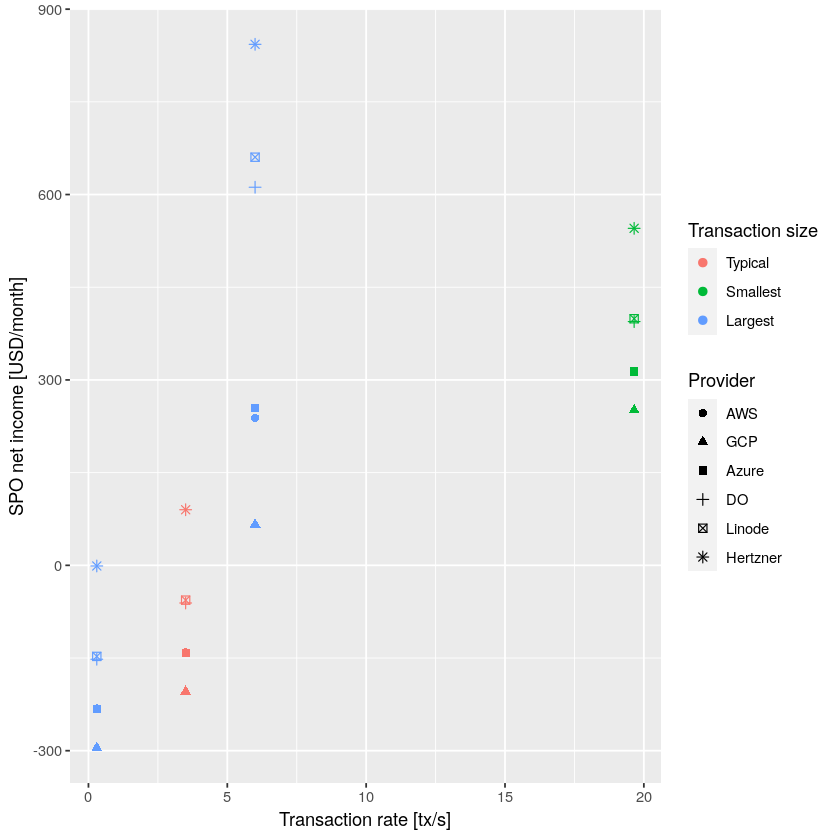

In [15]:
ggplot(results[`SPO net income [USD/month]` < 1e3], aes(x=`Transaction rate [tx/s]`, y=`SPO net income [USD/month]`, color=`Transaction size`, shape=`Provider`)) +
    geom_point(size=2)

### Net income as a function of IB rate

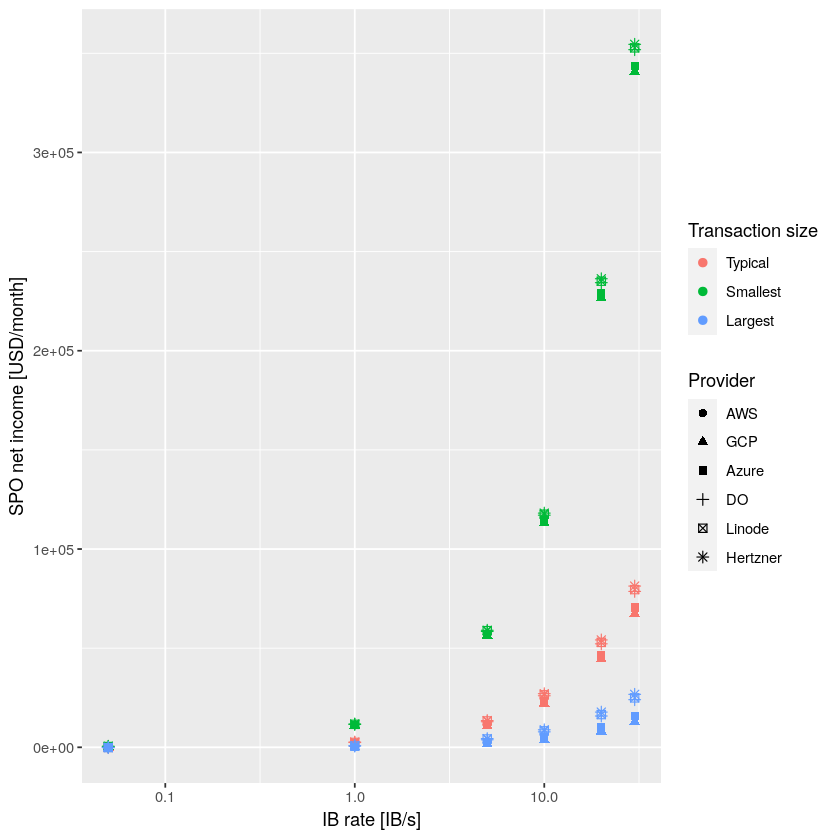

In [16]:
ggplot(results, aes(x=`IB rate [IB/s]`, y=`SPO net income [USD/month]`, color=`Transaction size`, shape=`Provider`)) +
    geom_point(size=2) +
    scale_x_log10()

Zoom in so the negative values are visible.

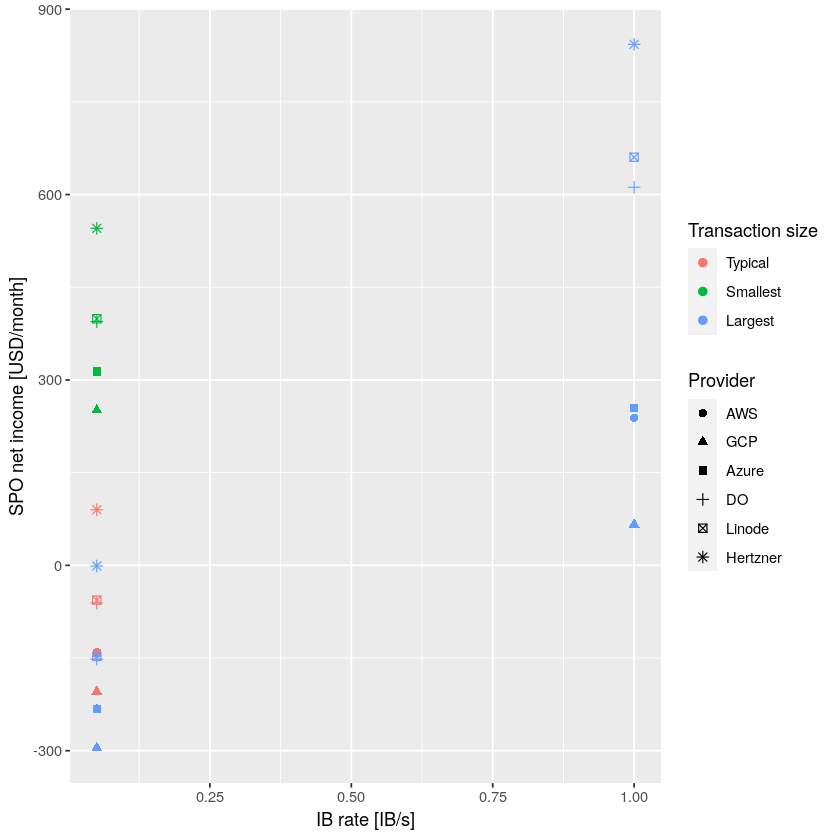

In [17]:
ggplot(results[`SPO net income [USD/month]` < 1e3], aes(x=`IB rate [IB/s]`, y=`SPO net income [USD/month]`, color=`Transaction size`, shape=`Provider`)) +
    geom_point(size=2)

### Revenue/cost ratio as a function of transaction rate

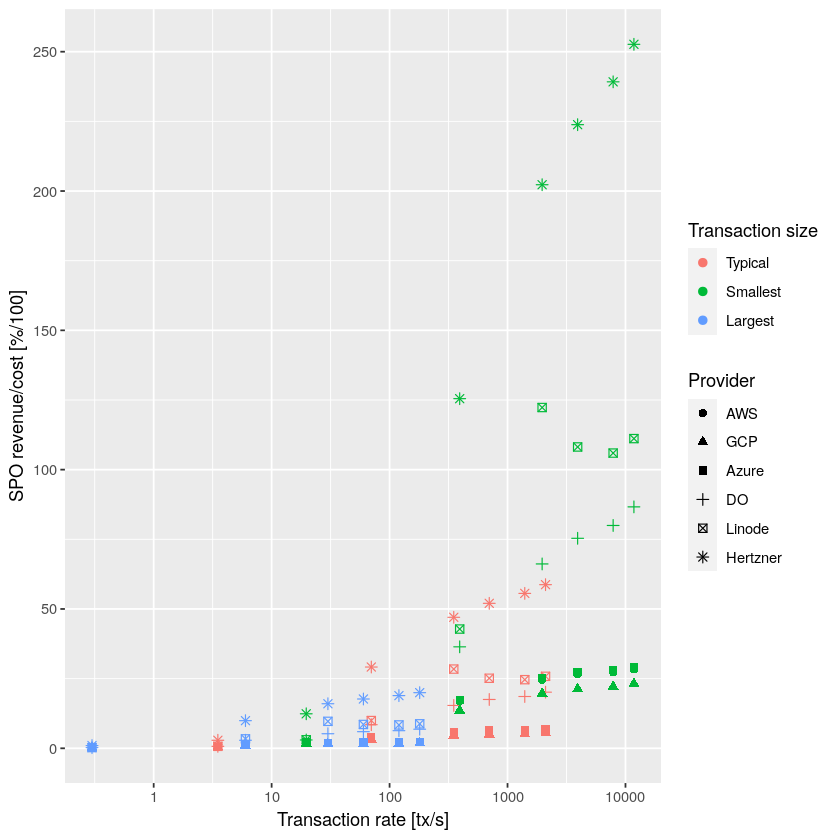

In [18]:
ggplot(results, aes(x=`Transaction rate [tx/s]`, y=`SPO revenue/cost [%/100]`, color=`Transaction size`, shape=`Provider`)) +
    geom_point(size=2) +
    scale_x_log10()

Zoom in so the small ratios are visible.

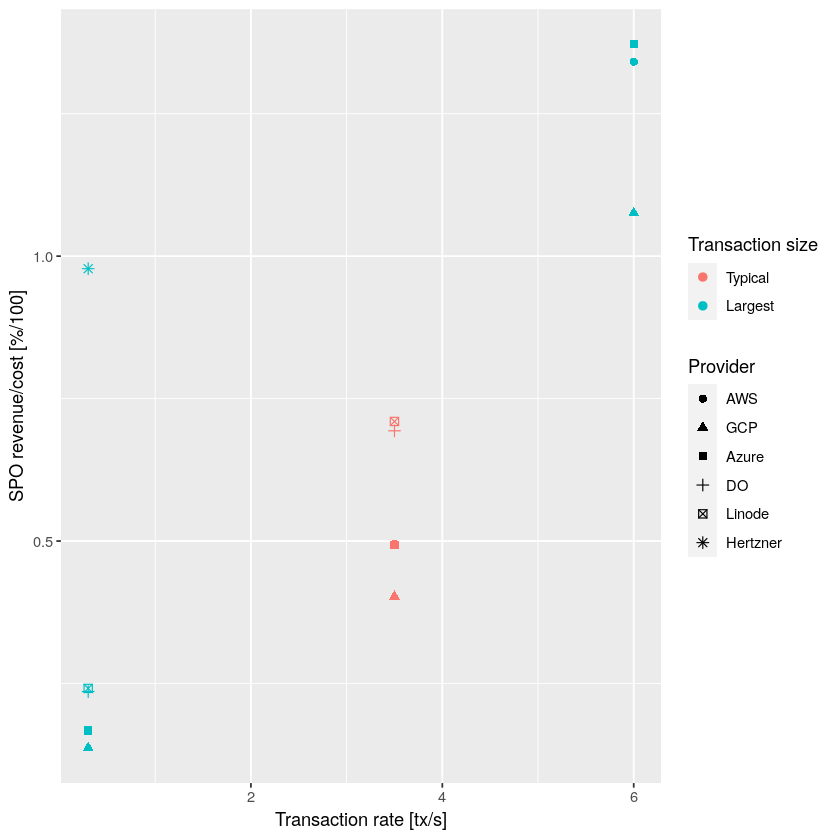

In [19]:
ggplot(results[`SPO revenue/cost [%/100]` < 1.5], aes(x=`Transaction rate [tx/s]`, y=`SPO revenue/cost [%/100]`, color=`Transaction size`, shape=`Provider`)) +
    geom_point(size=2)

### Revenue/cost ratio as a function of IB rate

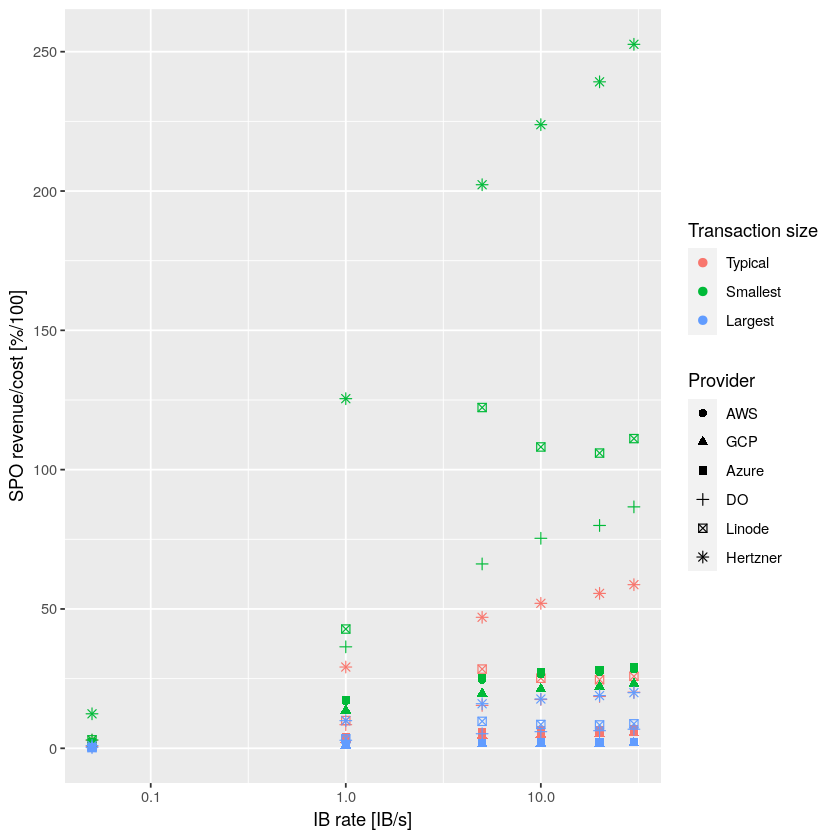

In [20]:
ggplot(results, aes(x=`IB rate [IB/s]`, y=`SPO revenue/cost [%/100]`, color=`Transaction size`, shape=`Provider`)) +
    geom_point(size=2) +
    scale_x_log10()

Zoom in so the small ratios are visible.

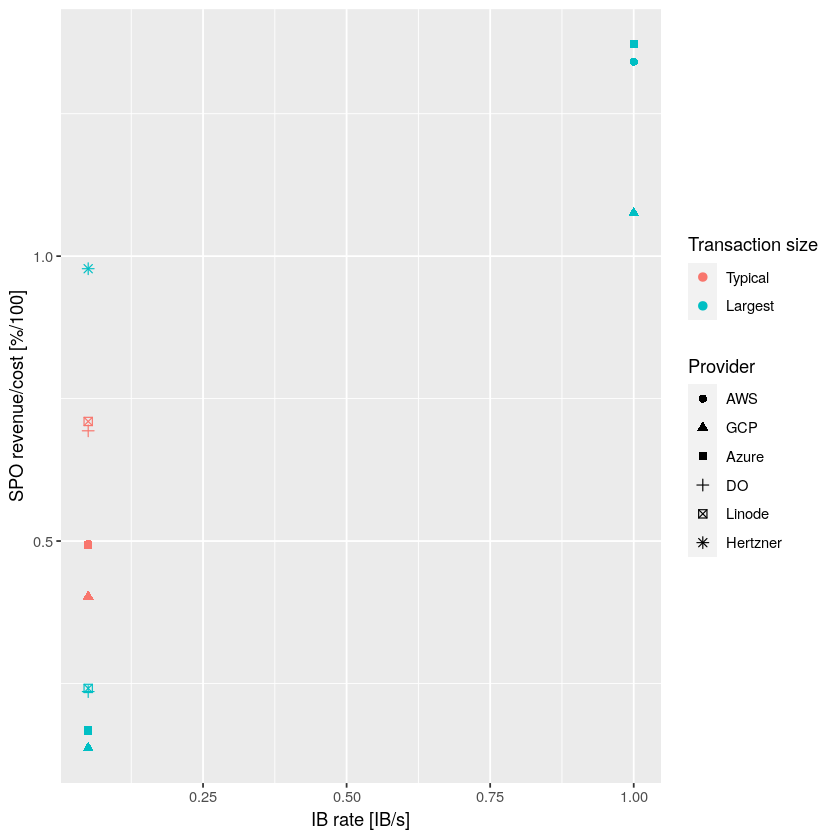

In [21]:
ggplot(results[`SPO revenue/cost [%/100]` < 1.5], aes(x=`IB rate [IB/s]`, y=`SPO revenue/cost [%/100]`, color=`Transaction size`, shape=`Provider`)) +
    geom_point(size=2)

## Notional forecast

### Assumptions

In [22]:
breakevenReward <- 1628532.454779  # ADA/epoch for SPOs

In [23]:
feePerTx = 0.34  # ADA/tx

In [24]:
breakevenTps = 0.6  # tx/s

In [25]:
breakevenPrice = 0.75  # USD/ADA

In [26]:
feeToSpo <- 0.21  # fraction reward to SPOs

In [27]:
secondsPerMonth <- 365.24 / 12 * 24 * 60 * 60

In [28]:
nodesPerSpo <- 3

In [29]:
spos <- 2500

### Grouping of cloud providers

In [30]:
groups <- data.table(
    `Provider`=c("AWS", "GCP", "Azure", "DO", "Linode", "Hertzner"),
    `Group`=factor(c("Premium", "Premium", "Premium", "Value", "Value", "Value"))
)
groups

Provider,Group
<chr>,<fct>
AWS,Premium
GCP,Premium
Azure,Premium
DO,Value
Linode,Value
Hertzner,Value


### Allocation of rewards

We allocate rewards in proportion to perceived costs, justified by the assumption that SPOs of different hosting are each approximately break-even at the current ada price.

In [31]:
allocation <- groups[results[`Transaction size` == "Typical" & `IB rate [IB/s]` == 0.05], on="Provider"][, .(`Allocation [%/100]`=mean(`SPO cost [USD/month]`)), .(`Group`)]
allocation[, `Allocation [%/100]`:=`Allocation [%/100]`/allocation[, sum(`Allocation [%/100]`)]]
allocation

Group,Allocation [%/100]
<fct>,<dbl>
Premium,0.6712804
Value,0.3287196


### Interpolation of expenses

The plots in the first section indicate that the expense relationship is linear enough that we can interpolate.

In [32]:
results2 <- allocation[groups[results[`Transaction size` == "Typical"], on="Provider"], on="Group"][,
    .(
        `Expenses [USD/month]`=nodesPerSpo*mean(`SPO cost [USD/month]`)
    ),
    .(
    `Provider`=`Group`,
    `Transaction rate [tx/s]`
    )
]
results2

Provider,Transaction rate [tx/s],Expenses [USD/month]
<fct>,<dbl>,<dbl>
Premium,3.5,900.63
Value,3.5,441.03
Premium,70.0,2254.32
Value,70.0,697.62
Premium,350.0,7780.29
Value,350.0,1675.05
Premium,700.0,14362.80
Value,700.0,3201.60
Premium,1400.0,27832.92


In [33]:
interpHyperscale <- approx(
    results2[`Provider` == "Premium", `Transaction rate [tx/s]`],
    results2[`Provider` == "Premium", `Expenses [USD/month]`],
    4:1000,
    method = "linear"
)
interpDiscount <- approx(
    results2[`Provider` == "Value", `Transaction rate [tx/s]`],
    results2[`Provider` == "Value", `Expenses [USD/month]`],
    4:1000,
    method = "linear"
)

In [34]:
interpResults <- rbind(
    data.table(
        `Cloud hosting`=factor("Premium", levels=c("Value", "Premium")),
        `Allocation [%/100]`=allocation[`Group` == "Premium", `Allocation [%/100]`],
        `Transaction rate [tx/s]`=interpHyperscale$x,
        `Expenses [USD/month]`=interpHyperscale$y
    ),
    data.table(
        `Cloud hosting`=factor("Value", levels=c("Value", "Premium")),
        `Allocation [%/100]`=allocation[`Group` == "Value", `Allocation [%/100]`],
        `Transaction rate [tx/s]`=interpDiscount$x,
        `Expenses [USD/month]`=interpDiscount$y
    )
)[,
    .(
        `Expenses [USD/month]`,
        `Revenue [USD/month]`=`Transaction rate [tx/s]`*feePerTx*breakevenPrice*secondsPerMonth*feeToSpo/spos*`Allocation [%/100]`,
        `Revenue / expense ratio [%]`=100*(`Transaction rate [tx/s]`*feePerTx*breakevenPrice*secondsPerMonth*feeToSpo/spos*`Allocation [%/100]`)/`Expenses [USD/month]`
), .(
        `Cloud hosting`,
        `Transaction rate [tx/s]`,
        `Throughput [TxkB/s]`=1.400*`Transaction rate [tx/s]`,
        `Throughput [TxMB/s]`=0.001400*`Transaction rate [tx/s]`,
        `Allocation [%/100]`
)]


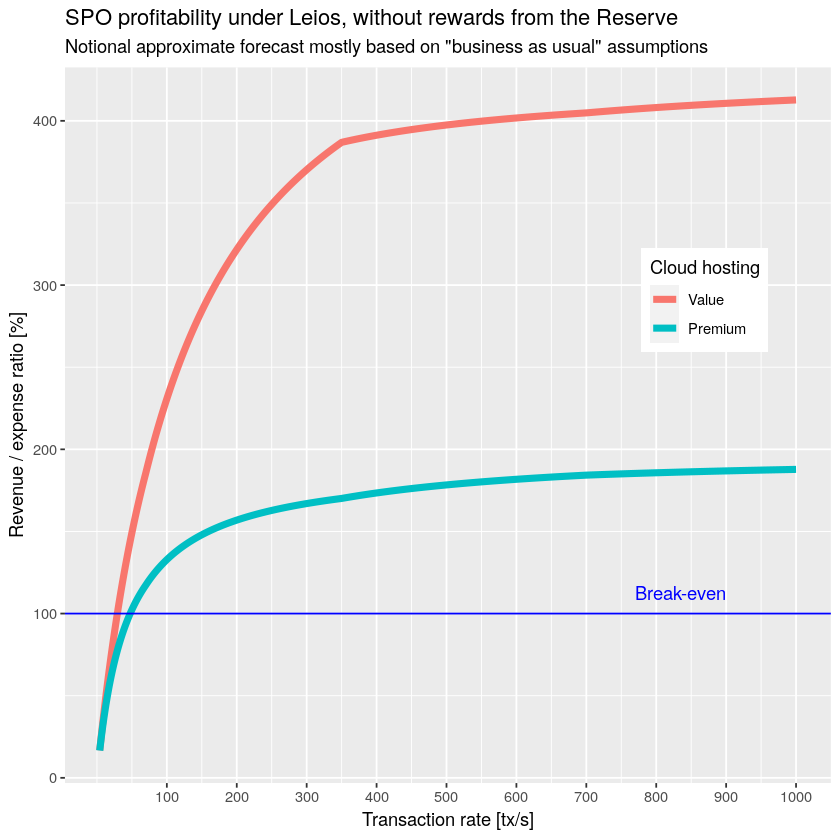

In [35]:
ggplot(interpResults, aes(x=`Transaction rate [tx/s]`, y=`Revenue / expense ratio [%]`, color=`Cloud hosting`)) +
    geom_line(linewidth=2) +
    geom_hline(yintercept=100, color="blue") +
    annotate("text", label="Break-even", x=900, y=100, color="blue", hjust=1, vjust=-1) +
    scale_x_continuous(breaks=100*1:10) +
    ggtitle(
        "SPO profitability under Leios, without rewards from the Reserve",
        subtitle="Notional approximate forecast mostly based on \"business as usual\" assumptions"
    ) +
    theme(legend.position=c(0.835,0.675))

In [36]:
ggsave("leios-forecast-linear.png", units="in", dpi=150, width=8, height=6)

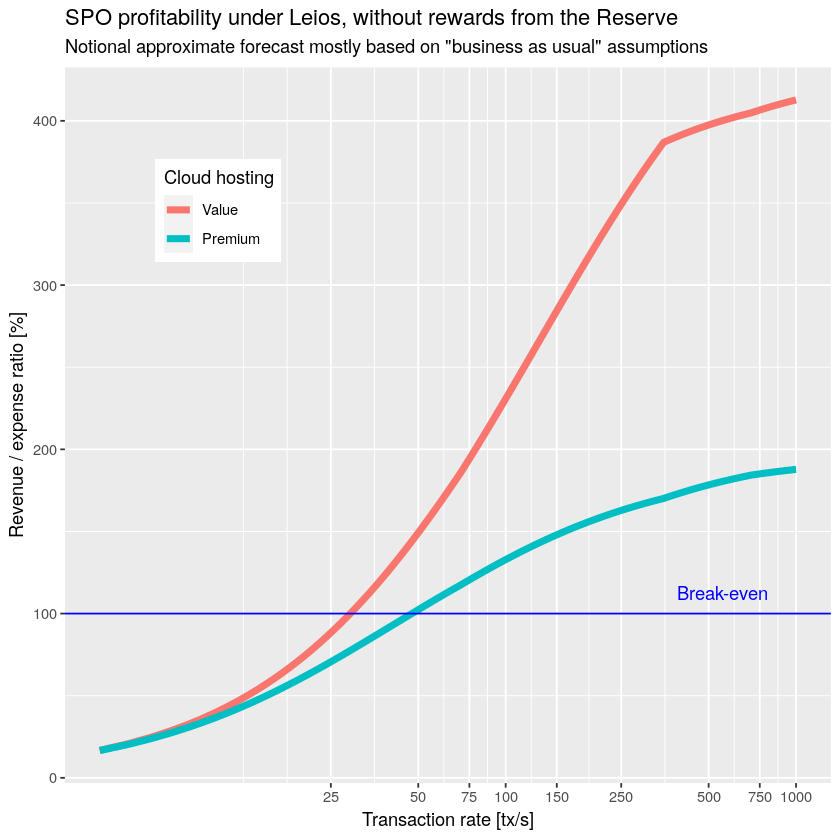

In [37]:
ggplot(interpResults, aes(x=`Transaction rate [tx/s]`, y=`Revenue / expense ratio [%]`, color=`Cloud hosting`)) +
    geom_line(linewidth=2) +
    geom_hline(yintercept=100, color="blue") +
    annotate("text", label="Break-even", x=800, y=100, color="blue", hjust=1, vjust=-1) +
    scale_x_log10(breaks=c(25,50,75,100,150,250,500,750,1000)) +
    ggtitle(
        "SPO profitability under Leios, without rewards from the Reserve",
        subtitle="Notional approximate forecast mostly based on \"business as usual\" assumptions"
    ) +
    theme(legend.position=c(0.2,0.8))

In [38]:
ggsave("leios-forecast-log10.png", units="in", dpi=150, width=8, height=6)

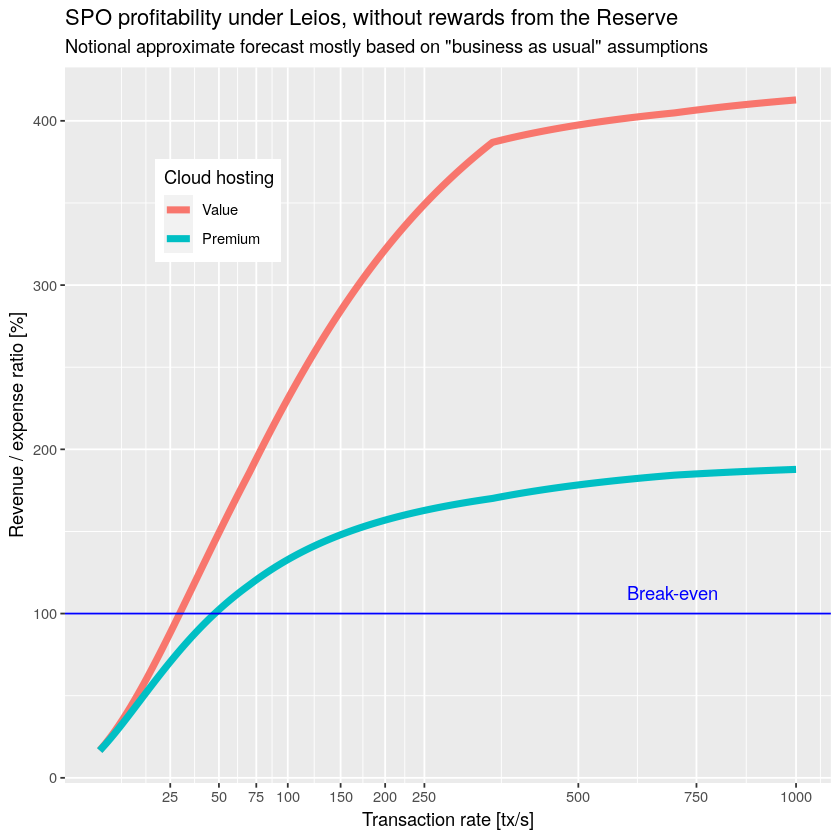

In [39]:
ggplot(interpResults, aes(x=`Transaction rate [tx/s]`, y=`Revenue / expense ratio [%]`, color=`Cloud hosting`)) +
    geom_line(linewidth=2) +
    geom_hline(yintercept=100, color="blue") +
    annotate("text", label="Break-even", x=800, y=100, color="blue", hjust=1, vjust=-1) +
    scale_x_sqrt(breaks=c(25,50,75,100,150,200,250,500,750,1000)) +
    ggtitle(
        "SPO profitability under Leios, without rewards from the Reserve",
        subtitle="Notional approximate forecast mostly based on \"business as usual\" assumptions"
    ) +
    theme(legend.position=c(0.2,0.8))

In [40]:
ggsave("leios-forecast-sqrt.png", units="in", dpi=150, width=8, height=6)

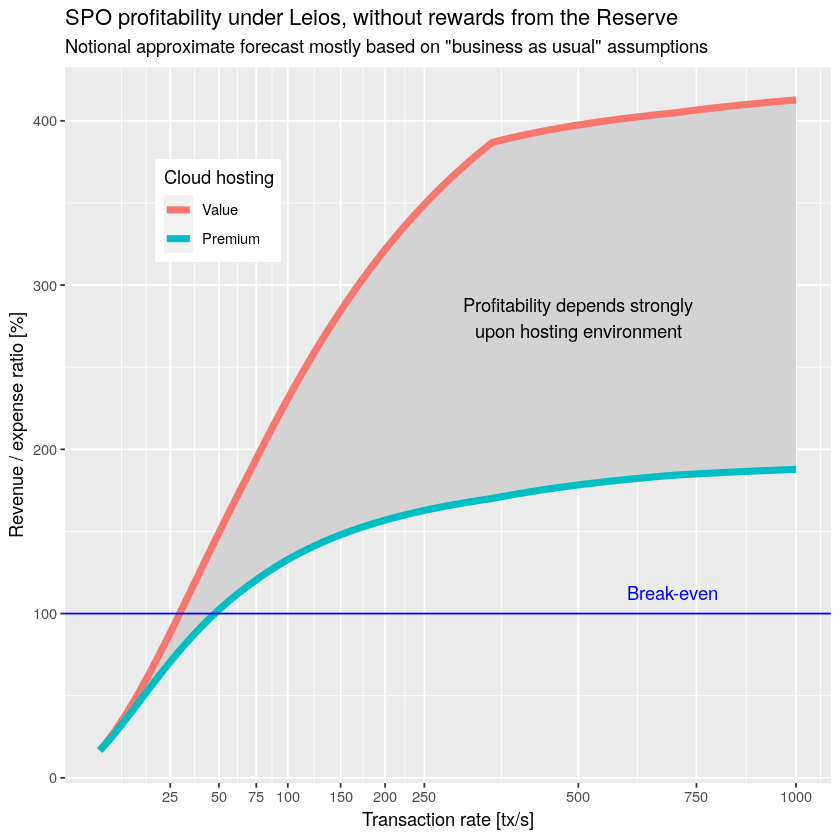

In [41]:
ggplot(interpResults, aes(x=`Transaction rate [tx/s]`, y=`Revenue / expense ratio [%]`, color=`Cloud hosting`)) +
    geom_ribbon(
        data=dcast(interpResults, `Transaction rate [tx/s]` ~ `Cloud hosting`, value.var="Revenue / expense ratio [%]"),
        aes(x=`Transaction rate [tx/s]`, ymin=`Premium`, ymax=`Value`),
        color=NA, y=NA, fill="lightgray"
    ) +
    annotate("text", label="Profitability depends strongly\nupon hosting environment", x=500, y=280) +
    geom_line(linewidth=2) +
    geom_hline(yintercept=100, color="blue") +
    annotate("text", label="Break-even", x=800, y=100, color="blue", hjust=1, vjust=-1) +
    scale_x_sqrt(breaks=c(25,50,75,100,150,200,250,500,750,1000)) +
    ggtitle(
        "SPO profitability under Leios, without rewards from the Reserve",
        subtitle="Notional approximate forecast mostly based on \"business as usual\" assumptions"
    ) +
    theme(legend.position=c(0.2,0.8))

In [42]:
ggsave("leios-forecast-sqrt-fill.png", units="in", dpi=150, width=8, height=6)

In [43]:
ggsave("leios-forecast-sqrt-fill.svg", units="in", dpi=150, width=8, height=6)

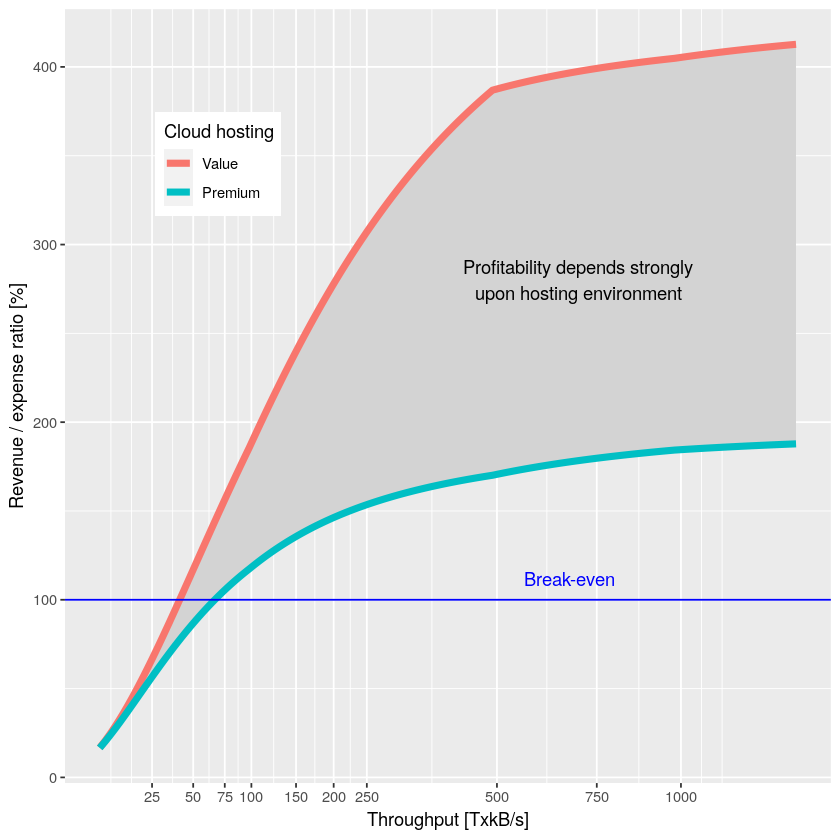

In [44]:
ggplot(interpResults, aes(x=`Throughput [TxkB/s]`, y=`Revenue / expense ratio [%]`, color=`Cloud hosting`)) +
    geom_ribbon(
        data=dcast(interpResults, `Throughput [TxkB/s]` ~ `Cloud hosting`, value.var="Revenue / expense ratio [%]"),
        aes(x=`Throughput [TxkB/s]`, ymin=`Premium`, ymax=`Value`),
        color=NA, y=NA, fill="lightgray"
    ) +
    annotate("text", label="Profitability depends strongly\nupon hosting environment", x=700, y=280) +
    geom_line(linewidth=2) +
    geom_hline(yintercept=100, color="blue") +
    annotate("text", label="Break-even", x=800, y=100, color="blue", hjust=1, vjust=-1) +
    scale_x_sqrt(breaks=c(25,50,75,100,150,200,250,500,750,1000)) +
#   ggtitle(
#       "SPO profitability under Leios, without rewards from the Reserve",
#       subtitle="Notional approximate forecast mostly based on \"business as usual\" assumptions"
#   ) +
    theme(legend.position=c(0.2,0.8))

In [45]:
ggsave("leios-forecast-sqrt-fill-cip.png", units="in", dpi=150, width=8, height=6)

In [46]:
ggsave("leios-forecast-sqrt-fill-cip.svg", units="in", dpi=150, width=8, height=6)

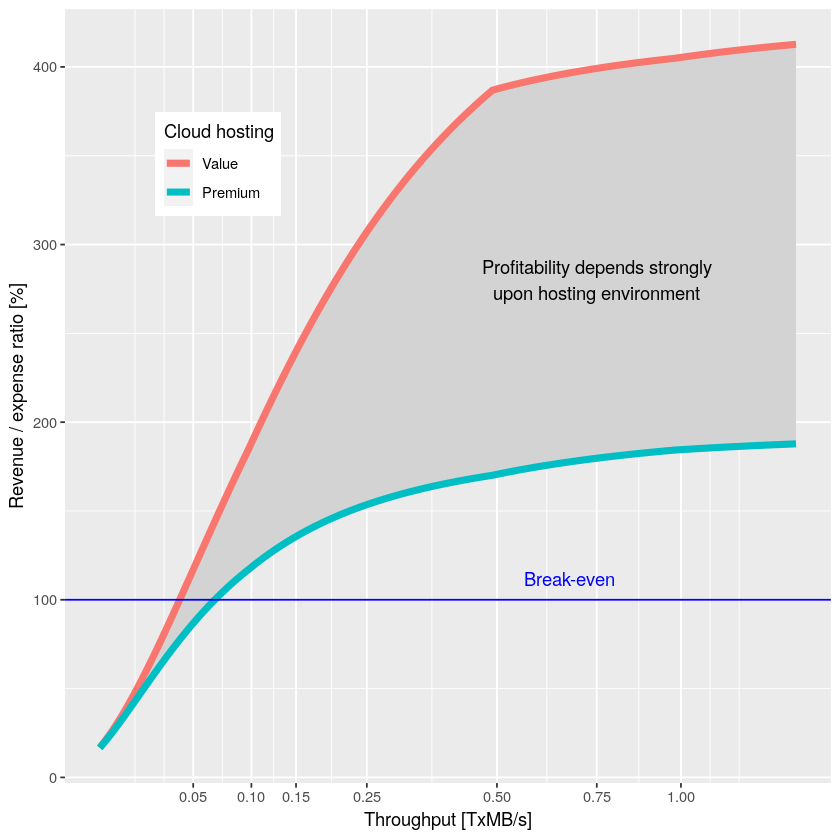

In [47]:
ggplot(interpResults, aes(x=`Throughput [TxMB/s]`, y=`Revenue / expense ratio [%]`, color=`Cloud hosting`)) +
    geom_ribbon(
        data=dcast(interpResults, `Throughput [TxMB/s]` ~ `Cloud hosting`, value.var="Revenue / expense ratio [%]"),
        aes(x=`Throughput [TxMB/s]`, ymin=`Premium`, ymax=`Value`),
        color=NA, y=NA, fill="lightgray"
    ) +
    annotate("text", label="Profitability depends strongly\nupon hosting environment", x=0.750, y=280) +
    geom_line(linewidth=2) +
    geom_hline(yintercept=100, color="blue") +
    annotate("text", label="Break-even", x=0.800, y=100, color="blue", hjust=1, vjust=-1) +
    scale_x_sqrt(breaks=c(0.050,0.100,0.150,0.250,0.500,0.750,1.000)) +
#   ggtitle(
#       "SPO profitability under Leios, without rewards from the Reserve",
#       subtitle="Notional approximate forecast mostly based on \"business as usual\" assumptions"
#   ) +
    theme(legend.position=c(0.2,0.8))

In [48]:
ggsave("leios-forecast-sqrt-fill-cip-mb.png", units="in", dpi=150, width=8, height=6)

In [49]:
ggsave("leios-forecast-sqrt-fill-cip-mb.svg", units="in", dpi=150, width=8, height=6)